In [439]:
import numpy as np
import pandas as pd
import pickle
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint
import datetime

### Find Tickers
We would like to identify cointegrated pairs.
One way to find them is to look into some specific sectors.
For exp: 'utilities.csv' includes a list of active utilities.

In [448]:
filename='utilities.csv'
#filename='minerals.csv'
#filename='reit.csv'
#filename='etf.csv'
#filename='banks.csv'
df = pd.read_csv(filename)
df.head()

,Ticker,Description,Price,Change %,Change,Technical Rating,Volume,Volume*Price,Market Capitalization,Price to Earnings Ratio (TTM),Basic EPS (TTM),Number of Employees,Sector
0,PCG,Pacific Gas & Electric Co.,13.83,-3.354298,-0.48,Buy,24222506,3.349973e+08,2.748945e+10,185.844156,0.1064,26000.0,Utilities
1,RUN,Sunrun Inc.,21.21,-7.621951,-1.75,Strong Sell,10480596,2.222934e+08,4.498730e+09,NaN,-0.5481,11383.0,Utilities
2,NEE,"NextEra Energy, Inc.",71.77,-1.805993,-1.32,Sell,8735692,6.269606e+08,1.425650e+11,55.960493,1.3138,15000.0,Utilities
3,EXC,Exelon Corporation,36.59,-1.719044,-0.64,Sell,6830065,2.499121e+08,3.628839e+10,13.743079,2.7108,31518.0,Utilities
4,FE,FirstEnergy Corp.,36.17,-2.559267,-0.95,Strong Sell,6503663,2.352375e+08,2.066737e+10,15.636716,2.3782,12395.0,Utilities


We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [449]:
 # Define a volume cap
volume_cap = 1000000

df = df[['Ticker','Description','Volume','Price']].sort_values(by='Volume', ascending=False)
high_volume = df.Volume>volume_cap
df_h = df[high_volume]
tickers = df_h.Ticker.tolist()
tickers

['PCG',
 'RUN',
 'NEE',
 'EXC',
 'FE',
 'PPL',
 'NI',
 'NOVA',
 'CNP',
 'SO',
 'DUK',
 'D',
 'AES',
 'AEP',
 'XEL',
 'ED',
 'EIX',
 'DTE',
 'CLNE',
 'VST',
 'LNT',
 'CMS',
 'ES',
 'PEG',
 'WEC',
 'SRE',
 'CEG',
 'NRG',
 'RNW',
 'AGR',
 'OGE',
 'AEE',
 'WTRG',
 'AWK',
 'UGI',
 'ETR',
 'AMPS']

In [450]:
 # Define a price interval if needed
price_low = 20 
price_high = 100

query="Price>"+str(price_low)+" & Price<"+str(price_high)
df_h_p = df_h.query(query)
tickers = df_h_p.Ticker.tolist()
tickers

['RUN',
 'NEE',
 'EXC',
 'FE',
 'PPL',
 'NI',
 'CNP',
 'SO',
 'DUK',
 'D',
 'AES',
 'AEP',
 'XEL',
 'ED',
 'EIX',
 'VST',
 'LNT',
 'CMS',
 'ES',
 'PEG',
 'WEC',
 'CEG',
 'NRG',
 'AGR',
 'OGE',
 'AEE',
 'WTRG',
 'UGI']

### Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to downloed the closing prices of stocks.
More information is available on the next notebook which we will download and save a more detailed stock data.

In [452]:
# Enable to use start & end dates:
# start = datetime.datetime(2018, 1, 1)
# end = datetime.datetime(2022, 1, 1)

#df = yf.download(tickers, start, end)["Close"]

# enable to use periods & intervals
period = '1y'
interval = '1d'
df = yf.download(tickers, period=period, interval=interval)["Close"]

df.info()

[*********************100%***********************]  28 of 28 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-10-28 00:00:00-04:00 to 2022-10-28 00:00:00-04:00
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEE     252 non-null    float64
 1   AEP     252 non-null    float64
 2   AES     252 non-null    float64
 3   AGR     252 non-null    float64
 4   CEG     197 non-null    float64
 5   CMS     252 non-null    float64
 6   CNP     252 non-null    float64
 7   D       252 non-null    float64
 8   DUK     252 non-null    float64
 9   ED      252 non-null    float64
 10  EIX     252 non-null    float64
 11  ES      252 non-null    float64
 12  EXC     252 non-null    float64
 13  FE      252 non-null    float64
 14  LNT     252 non-null    float64
 15  NEE     252 non-null    float64
 16  NI      252 non-null    float64
 17  NRG     252 non-null    float64
 18  OGE     252 non-null    float6

Check for null values and eliminate them:

It is important to check the dataframe for Na rows & columns before moving forward. Downloaded data may not be consistent all the time, so better doing it manually before proceeding:

In [454]:
df.head()

,AEE,AEP,AES,AGR,CEG,CMS,CNP,D,DUK,ED,...,OGE,PEG,PPL,RUN,SO,UGI,VST,WEC,WTRG,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-28 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-29 00:00:00-04:00,84.290001,84.709999,25.129999,52.700001,NaN,60.349998,26.040001,75.930000,102.010002,75.400002,...,34.070000,63.799999,28.799999,57.680000,62.320000,43.410000,19.590000,90.059998,47.070000,64.589996
2021-11-01 00:00:00-04:00,84.279999,85.129997,25.370001,52.580002,NaN,60.290001,26.290001,75.410004,102.309998,76.110001,...,34.669998,64.360001,29.299999,58.189999,62.480000,44.389999,20.010000,90.339996,47.049999,64.500000
2021-11-02 00:00:00-04:00,84.330002,85.300003,25.370001,52.619999,NaN,60.439999,26.190001,75.489998,102.449997,76.440002,...,34.480000,63.980000,29.240000,57.720001,62.490002,44.349998,19.870001,90.889999,47.270000,64.709999
2021-11-03 00:00:00-04:00,84.190002,84.930000,25.299999,51.599998,NaN,60.150002,26.290001,75.480003,102.540001,76.980003,...,34.590000,63.369999,29.309999,58.310001,62.549999,44.520000,19.680000,89.870003,47.259998,63.500000


In [463]:
df = df.dropna(axis=0, how='all') # check if necessary
df = df.dropna(axis=1) # check if necessary
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
df.to_pickle("close_prices.pkl")
df.info()

we have 27 tickers left
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-10-29 00:00:00-04:00 to 2022-10-28 00:00:00-04:00
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEE     252 non-null    float64
 1   AEP     252 non-null    float64
 2   AES     252 non-null    float64
 3   AGR     252 non-null    float64
 4   CMS     252 non-null    float64
 5   CNP     252 non-null    float64
 6   D       252 non-null    float64
 7   DUK     252 non-null    float64
 8   ED      252 non-null    float64
 9   EIX     252 non-null    float64
 10  ES      252 non-null    float64
 11  EXC     252 non-null    float64
 12  FE      252 non-null    float64
 13  LNT     252 non-null    float64
 14  NEE     252 non-null    float64
 15  NI      252 non-null    float64
 16  NRG     252 non-null    float64
 17  OGE     252 non-null    float64
 18  PEG     252 non-null    float64
 19  PPL     252 non-null    float64
 20  RUN

### Find Cointegrated Pairs

We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

In [464]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue
            
            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))
                
    return stats, pvalues, pairs

See the result on a heatmap

[('AEE', 'DUK'), ('AEP', 'CNP'), ('AEP', 'OGE'), ('AEP', 'VST'), ('CMS', 'DUK'), ('CNP', 'VST'), ('ED', 'VST'), ('OGE', 'XEL')]


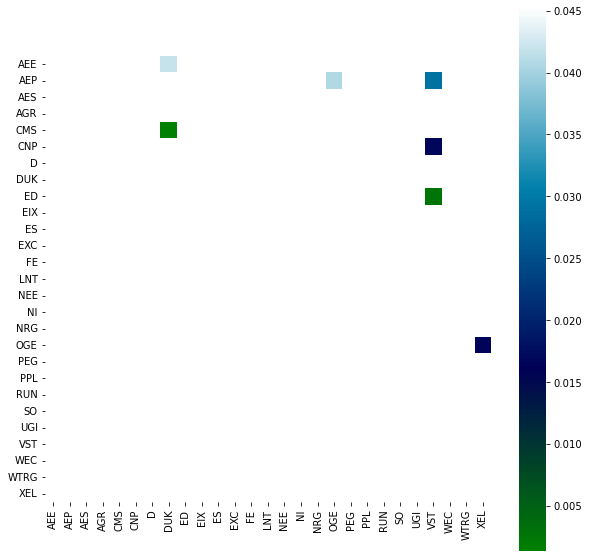

In [465]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

### Filter For More Significant Pairs
Filter more to get more significant pairs, and eliminate empty cells.

,CNP,DUK,OGE,VST,XEL
AEE,nan,0.042,nan,nan,nan
AEP,0.045,nan,0.041,0.029,nan
CMS,nan,0.001,nan,nan,nan
CNP,nan,nan,nan,0.017,nan
ED,nan,nan,nan,0.003,nan
OGE,nan,nan,nan,nan,0.016


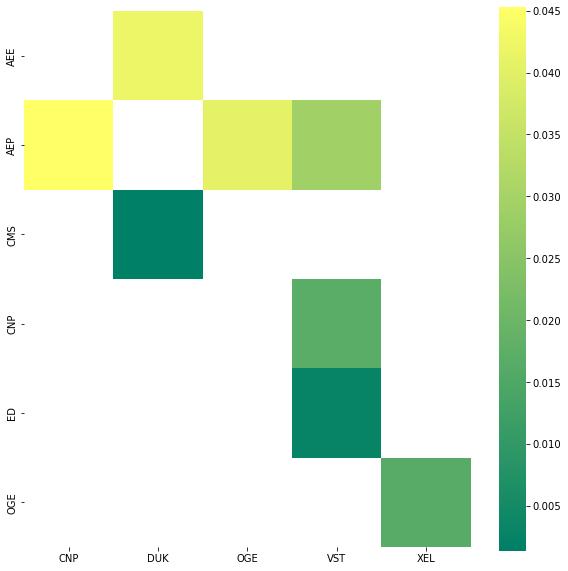

In [466]:
mask_matrix = (pvalues >= 0.05) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color

# Another way to format table is applymap
# def color_map(x):
#     return f"color: {'red' if x > 0 else 'white'}"

# df_f.style.applymap(color_map)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3)\
.apply(gold_apply)

### EXERCISE: Get List/Dic of Pairs

In [467]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('AEE', 'DUK'),
 ('AEP', 'CNP'),
 ('AEP', 'OGE'),
 ('AEP', 'VST'),
 ('CMS', 'DUK'),
 ('CNP', 'VST'),
 ('ED', 'VST'),
 ('OGE', 'XEL')]

In [468]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])
    
new_pairs_str

[['CNP-AEP'],
 ['DUK-AEE', 'DUK-CMS'],
 ['OGE-AEP'],
 ['VST-AEP', 'VST-CNP', 'VST-ED'],
 ['XEL-OGE']]

In [469]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'CNP': ['AEP'],
 'DUK': ['AEE', 'CMS'],
 'OGE': ['AEP'],
 'VST': ['AEP', 'CNP', 'ED'],
 'XEL': ['OGE']}

### Save to file
Save dataframa as pickle to use for the next steps

In [470]:
df_f.to_pickle("pairs_to_download.pkl")